# Lezione 24

L'installazione della *toolchain* LLVM (nella versione 10, come richiesta da queste note) potrebbe non essere banale; chi usa [Docker](https://www.docker.com/) può utilizzare l'immagine [mapio/let-llvm](https://hub.docker.com/repository/docker/mapio/let-llvm) con il comando seguente

    docker run --rm -it -p 8888:8888 -v $(pwd):/home/jovyan mapio/let-llvm
    
per invocare un ambiente di esecuzione preconfigurato col software necessario.

In [ ]:
from liblet import ANTLR, LLVM, AnnotatedTreeWalker, union_of, __version__

from symboltable import SymbolTable

__version__

'1.4.0-alpha'

## Uso minimale dell'IR di LLVM

Il manuale di [riferimento del linguaggio](https://IR.org/docs/LangRef.html) descrive gli aspetti sintattici e semantici dell'IR, in particolare può essere utile la parte sulle [istruzioni](https://llvm.org/docs/LangRef.html#instruction-reference).

Nel seguito ci limiteremo alle seguenti

    %ptr = alloca i32
    store i32 %var, i32* %ptr
    %var = load i32, i32* %ptr
    
    %res = add i32 %left, %right
    %res = sub i32 %left, %right
    %res = mul i32 %left, %right

    %bool = icmp eq i32 %left, %right
    %bool = icmp sge i32 %left, 0
    
    %br label %label
    %br i1 %bool, label %true, label %false

    call void @print(i32 %var)
    %res = call i32 @input()
    
come esempio consideriamo il sorgente

In [ ]:
source = """
%v1 = call i32 @input()
%v2 = add i32 %v1, 1
call void @print(i32 %v2)
"""

Per poterlo compilare è necessario avvolgerlo in una funzione e definire opportunamente le funzioni `input` e `input` (in termni rispettivamente delle funzioni `scanf` e `printf` della libreria standard per il C).

In [ ]:
LLVM('addone', source).write_and_compile()

In [ ]:
! cat addone.ll


; ModuleID = 'addone.ll'
source_filename = "addone.ll"

@.decfmt.0 = internal constant [3 x i8] c"%d\00"
@.decfmt.1 = internal constant [4 x i8] c"%d\0A\00"

declare i32 @__isoc99_scanf(i8*, ...)
declare i32 @printf(i8*, ...)

define i32 @input() {
    %.1 = alloca i32
    %.2 = bitcast [3 x i8]* @.decfmt.0 to i8*
    %.3 = call i32 (i8*, ...) @__isoc99_scanf(i8* %.2, i32* %.1)
    %.4 = load i32, i32* %.1
    ret i32 %.4
}

define void @print(i32 %0) {
    %.1 = bitcast [4 x i8]* @.decfmt.1 to i8*
    %.2 = call i32 (i8*, ...) @printf(i8* %.1, i32 %0)
    ret void
}

define void @main() {
    entry:

            %v1 = call i32 @input()
            %v2 = add i32 %v1, 1
            call void @print(i32 %v2)

    ret void
}


Il codice è stato compilato con `clang`, quindi può essere posto in esecuzione come un qualunque eseguibile del sistema

In [ ]:
! echo 1 | ./addone

2


## Generazione del codice

Vediamo ora come generare l'IR a partire da un programma in *SimpleBlockLang*, per prima cosa recuperiamo il necessario per la generazione dell'AST

In [ ]:
SimpleBlockLang = ANTLR.load('SimpleBlockLang.g')
simpleBlock2ast = AnnotatedTreeWalker.load('simpleBlock2ast.atw')

def src2ast(source):
    return simpleBlock2ast(SimpleBlockLang.tree(source, 'program'))

Al solito, usiamo un `AnnotatedTreeWalker` di nome `codegen` che userà alcune variabili globali:

* `IR` (di tipo `LLVM`) in cui accumulerà l'IR e che userà per generare i nomi di variabili ed etichette,
* `ST` (di tipo `SymbolTable`) in cui terrà traccia delle allocazioni di variabile,

Queste variabili verranno inizializzate prima dell'invocazione di `codegen`.

In [ ]:
codegen = AnnotatedTreeWalker('type', AnnotatedTreeWalker.RECOURSE_CHILDREN)

Prima ci occupiamo delle espressioni, che restituiscono il nome della variabile dove hanno prodotto il risultato

In [ ]:
@codegen.register
def intExpr(visit, ast):
    return str(ast.root['value'])

@codegen.register
def varRefExpr(visit, ast):
    name = ast.root['varName']
    res = IR.new_variable()
    IR.append_code(f'{res} = load i32, i32* {ST.lookup(name)} ; {name}')
    return res
    
@codegen.register
def addSubExpr(visit, ast):
    left, right = ast.children
    left = visit(left)
    right = visit(right)
    res = IR.new_variable()
    op = 'add' if ast.root['op'] == '+' else 'sub'
    IR.append_code(f'{res} = {op} i32 {left}, {right}')
    return res 

@codegen.register
def prodExpr(visit, ast):
    left, right = ast.children
    left = visit(left)
    right = visit(right)
    res = IR.new_variable()
    IR.append_code(f'{res} = mul i32 {left}, {right}')
    return res

@codegen.register
def equalityExpr(visit, ast):
    left, right = ast.children
    left = visit(left)
    right = visit(right)
    res = IR.new_variable()
    IR.append_code(f'{res} = icmp eq i32 {left}, {right}')
    return res

Quindi ci occupiamo degli statement (che non restiuiscono nulla, ma alterano solo `CODE`)

In [ ]:
@codegen.register
def assignementStat(visit, ast):
    name = ast.root['varName']
    expr = visit(ast.children[0])
    IR.append_code(f'store i32 {expr}, i32* {ST.lookup(name)} ; {name}')

@codegen.register
def varDeclInitStat(visit, ast):
    name = ast.root['varName']
    ptr = IR.new_variable()
    ST.bind(name, ptr)
    expr = visit(ast.children[0])
    IR.append_code(f"""
        {ptr} = alloca i32 ; {name}
        store i32 {expr}, i32* {ptr}
    """)

@codegen.register
def repeatStat(visit, ast):
    count, stat = ast.children
    count = visit(count)
    tmp = IR.new_variable()
    repeat = IR.new_label()
    IR.append_code(f"""
        {tmp}.0 = alloca i32
        store i32 {count}, i32* {tmp}.0
        br label %{repeat}.test
        {repeat}.test:
        {tmp}.1 = load i32, i32* {tmp}.0
        {tmp}.2 = sub i32 {tmp}.1, 1
        store i32 {tmp}.2, i32* {tmp}.0
        {tmp}.3 = icmp sge i32 {tmp}.2, 0
        br i1 {tmp}.3, label %{repeat}.body, label %{repeat}.end
        {repeat}.body:
    """)
    visit(stat)
    IR.append_code(f"""
        br label %{repeat}.test
        {repeat}.end:
    """)

@codegen.register
def ifElseStat(visit, ast):
    cond, true, false = ast.children
    cond = visit(cond)
    label = IR.new_label()
    IR.append_code(f"""
        br i1 {cond}, label %{label}.true, label %{label}.false
        {label}.true:
    """)
    visit(true)
    IR.append_code(f"""
        br label %{label}.end
        {label}.false:
    """)
    visit(false)
    IR.append_code(f"""
        br label %{label}.end
        {label}.end:
    """)

Prima di poter procedere con la generazione, dobbiamo raccogliere tutti i nomi di variabili legate all'I/O

In [ ]:
def search_io(ast):
    names = union_of(search_io(child) for child in ast.children)
    if 'varName' in ast.root:
        name = ast.root['varName']
        if name.startswith('INPUT') or name == 'OUTPUT': 
            names |= {name}
    return names

Per ciascuna di esse la funzione `allocate_and_add_input` alloca lo spazio necessario e, per quelle di input, aggiunge le chiamate alla funzione `input`; la funzione `add_print` invece aggiunge una chiamata a `print` nel caso il programa abbia prodotto outpout. 

In [ ]:
def allocate_and_add_input(io_vars):
    for name in io_vars:
        ptr = IR.new_variable()
        ST.bind(name, ptr)
        IR.append_code(f'{ptr} = alloca i32 ; {name}')
        if name.startswith('INPUT'):
            tmp = IR.new_variable()
            IR.append_code(f"""
                {tmp} = call i32 @input()
                store i32 {tmp}, i32* {ptr} ; {name}
            """)
            
def add_print(io_vars):            
    if 'OUTPUT' in io_vars:
        tmp = IR.new_variable()
        IR.append_code(f"""
            {tmp} = load i32, i32* {ST.lookup("OUTPUT")}
            call void @print(i32 {tmp})
        """)            

Usiamo un programma che calcola il fattoriale dell'input, o restituisce -1 se l'input è pari a 0.

In [ ]:
fact = """
if INPUT0 == 0 then
    OUTPUT = 0 - 1;
else {
    var n = 0;
    var fact = 1;    
    repeat INPUT0 times {
        n = n + 1;
        fact = fact * n;
    }
    OUTPUT = fact;
}
"""

Facciamo i vari passi in ordine

In [ ]:
ast = src2ast(fact)

In [ ]:
IR = LLVM('fact')
ST = SymbolTable()

In [ ]:
io_vars = search_io(ast)
allocate_and_add_input(io_vars)
codegen(ast)
add_print(io_vars)

In [ ]:
IR.print_code()

%v0 = alloca i32 ; INPUT0
%v1 = call i32 @input()
store i32 %v1, i32* %v0 ; INPUT0
%v2 = alloca i32 ; OUTPUT
%v3 = load i32, i32* %v0 ; INPUT0
%v4 = icmp eq i32 %v3, 0
br i1 %v4, label %l0.true, label %l0.false
l0.true:
%v5 = sub i32 0, 1
store i32 %v5, i32* %v2 ; OUTPUT
br label %l0.end
l0.false:
%v6 = alloca i32 ; n
store i32 0, i32* %v6
%v7 = alloca i32 ; fact
store i32 1, i32* %v7
%v8 = load i32, i32* %v0 ; INPUT0
%v9.0 = alloca i32
store i32 %v8, i32* %v9.0
br label %l1.test
l1.test:
%v9.1 = load i32, i32* %v9.0
%v9.2 = sub i32 %v9.1, 1
store i32 %v9.2, i32* %v9.0
%v9.3 = icmp sge i32 %v9.2, 0
br i1 %v9.3, label %l1.body, label %l1.end
l1.body:
%v10 = load i32, i32* %v6 ; n
%v11 = add i32 %v10, 1
store i32 %v11, i32* %v6 ; n
%v12 = load i32, i32* %v7 ; fact
%v13 = load i32, i32* %v6 ; n
%v14 = mul i32 %v12, %v13
store i32 %v14, i32* %v7 ; fact
br label %l1.test
l1.end:
%v15 = load i32, i32* %v7 ; fact
store i32 %v15, i32* %v2 ; OUTPUT
br label %l0.end
l0.end:
%v16 = load i32, i32*

In [ ]:
IR.write_and_compile()

In [ ]:
! echo 6 | ./fact

720


## Una "ottimizzazione"

In [ ]:
nested = """
var n = 0;
repeat 3 times {
    repeat 2 times {
        n = n + 1;
    }
}
OUTPUT = n;
"""

In [ ]:
ast = src2ast(nested)
IR = LLVM('nested')
ST = SymbolTable()
io_vars = search_io(ast)
allocate_and_add_input(io_vars)
codegen(ast)
add_print(io_vars)
IR.print_code()

%v0 = alloca i32 ; OUTPUT
%v1 = alloca i32 ; n
store i32 0, i32* %v1
%v2.0 = alloca i32
store i32 3, i32* %v2.0
br label %l0.test
l0.test:
%v2.1 = load i32, i32* %v2.0
%v2.2 = sub i32 %v2.1, 1
store i32 %v2.2, i32* %v2.0
%v2.3 = icmp sge i32 %v2.2, 0
br i1 %v2.3, label %l0.body, label %l0.end
l0.body:
%v3.0 = alloca i32
store i32 2, i32* %v3.0
br label %l1.test
l1.test:
%v3.1 = load i32, i32* %v3.0
%v3.2 = sub i32 %v3.1, 1
store i32 %v3.2, i32* %v3.0
%v3.3 = icmp sge i32 %v3.2, 0
br i1 %v3.3, label %l1.body, label %l1.end
l1.body:
%v4 = load i32, i32* %v1 ; n
%v5 = add i32 %v4, 1
store i32 %v5, i32* %v1 ; n
br label %l1.test
l1.end:
br label %l0.test
l0.end:
%v6 = load i32, i32* %v1 ; n
store i32 %v6, i32* %v0 ; OUTPUT
%v7 = load i32, i32* %v0
call void @print(i32 %v7)


C'è una allocazione dentro al ciclo! Spostiamole tutte all'inizio…

In [ ]:
alloc = []
other = []
for istr in IR.code:
    (alloc if 'alloc' in istr else other).append(istr)
    
alloc

['%v0 = alloca i32 ; OUTPUT',
 '%v1 = alloca i32 ; n',
 '%v2.0 = alloca i32',
 '%v3.0 = alloca i32']

In [ ]:
IR.code = alloc + other

In [ ]:
IR.write_and_compile()

In [ ]:
! ./nested

6


## Analisi e ottimizzazione

Il comando [opt](https://IR.org/docs/CommandGuide/opt.html) consente di effettuare diversi passi di [analisi](https://llvm.org/docs/Passes.html#analysis-passes) e di [trasformazione](https://llvm.org/docs/Passes.html#transform-passes).

Le funzioni `control_flow_graph` e `mem2reg`, usando il comando `opt` con opportuni paramentri, producono rispettivamente il *control flow graph* e una ottimizzazione che sposta (quanto più possibile) dalla memoria ai registri le varabiili locali.

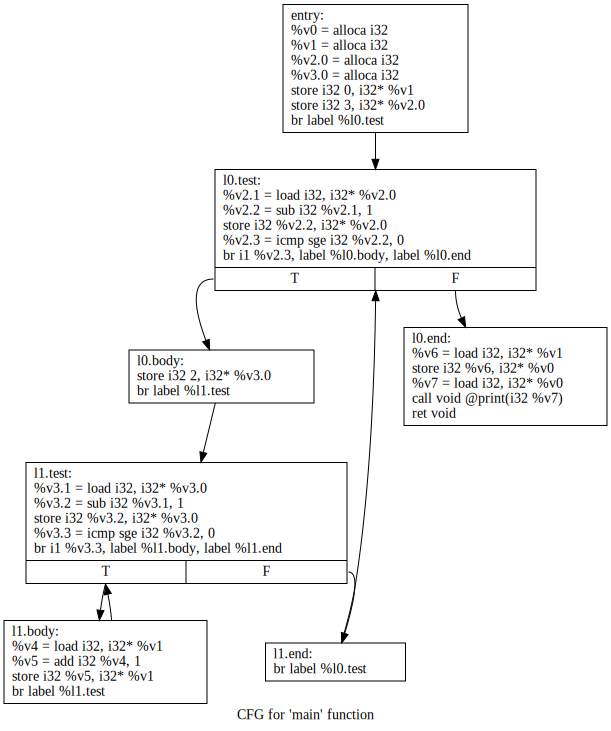

In [ ]:
IR.control_flow_graph()

In [ ]:
print(IR.mem2reg())

; ModuleID = 'nested.ll'
source_filename = "nested.ll"

@.decfmt.0 = internal constant [3 x i8] c"%d\00"
@.decfmt.1 = internal constant [4 x i8] c"%d\0A\00"

declare i32 @__isoc99_scanf(i8*, ...)

declare i32 @printf(i8*, ...)

define i32 @input() {
  %.1 = alloca i32
  %.2 = bitcast [3 x i8]* @.decfmt.0 to i8*
  %.3 = call i32 (i8*, ...) @__isoc99_scanf(i8* %.2, i32* %.1)
  %.4 = load i32, i32* %.1
  ret i32 %.4
}

define void @print(i32 %0) {
  %.1 = bitcast [4 x i8]* @.decfmt.1 to i8*
  %.2 = call i32 (i8*, ...) @printf(i8* %.1, i32 %0)
  ret void
}

define void @main() {
entry:
  br label %l0.test

l0.test:                                          ; preds = %l1.end, %entry
  %v2.0.0 = phi i32 [ 3, %entry ], [ %v2.2, %l1.end ]
  %v1.0 = phi i32 [ 0, %entry ], [ %v1.1, %l1.end ]
  %v2.2 = sub i32 %v2.0.0, 1
  %v2.3 = icmp sge i32 %v2.2, 0
  br i1 %v2.3, label %l0.body, label %l0.end

l0.body:                                          ; preds = %l0.test
  br label %l1.test

l1.test:   

## Documentazione e tutorial

Per i più curiosi di appronfondire LLVM e l'IR, un po' di siti interessanti sono:

* [A Complete Guide to LLVM for Programming Language Creators](https://mukulrathi.co.uk/create-your-own-programming-language/llvm-ir-cpp-api-tutorial/) contenete una introduzione molto completa, anche se orientata alle API in CPP di LLVM;

* La guida [Mapping High Level Constructs to LLVM IR](https://mapping-high-level-constructs-to-llvm-ir.readthedocs.io/) che contiene esempi su come tradurre costrutti di alto livello nell'IR;

* L'articolo [Writing your own programming language and compiler with Python](https://blog.usejournal.com/writing-your-own-programming-language-and-compiler-with-python-a468970ae6df) che descrive lo sviluppo di un linguaggio di programmazione (a partire dal *lexer* e dal *parser*) usando apposite librerie Python per il parsing e la generazione dell'IR), è disponibile anche il [codice sorgente](https://github.com/marcelogdeandrade/PythonCompiler).

* Un esempio analogo è la [versione Python](https://github.com/symhom/Kaleidoscope_Compiler) dello sviluppo del linguaggio *Kaleidoscope* descritto nel [LLVM Tutorial](https://IR.org/docs/tutorial/); sono utili in particolare gli [esempi](https://github.com/symhom/Kaleidoscope_Compiler/tree/master/short_llvmlite_examples) di traduzione di alcuni costrutti di alto livello in IR:

* Per finire, l'articolo [LLVM for Grad Students](https://www.cs.cornell.edu/~asampson/blog/IR.html) illustra la rilevanza di LLVM più che rispetto allo sviluppo di nuovi linguaggi, all'analisi e agli aspetti di ottimizzazione.
